In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.metrics import CategoricalCrossentropy 
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt

In [4]:
import tensorflow as tf

# List all physical GPUs
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available:", len(physical_devices))

# # Print detailed info about each GPU
# for i, gpu in enumerate(physical_devices):
#     details = tf.config.experimental.get_device_details(gpu)
#     print(f"GPU {i}: {gpu.name}, details: {details}")

# tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available: 0


In [10]:
# preserve_splits_by_prefix_fixed.py
import shutil
from pathlib import Path
import random
import csv

# CONFIG - change these if needed
DATASET_ROOT = Path("./Data")        
DEST_ROOT = Path("./Data_split")     
ALLOWED_EXT = {".jpg", ".jpeg", ".png", ".bmp"}
AUTO_FALLBACK = False   
FALLBACK_RATIOS = (0.8, 0.1, 0.1) 
DRY_RUN = False          # Set to False to actually move/copy files
COPY_INSTEAD_OF_MOVE = False  # If True, copy instead of move
RANDOM_SEED = 42

random.seed(RANDOM_SEED)
DEST_ROOT.mkdir(parents=True, exist_ok=True)
QUARANTINE = DEST_ROOT / "quarantine"
QUARANTINE.mkdir(parents=True, exist_ok=True)

# create destination structure
for split in ["train", "val", "test"]:
    (DEST_ROOT / split).mkdir(parents=True, exist_ok=True)

class_dirs = [d for d in DATASET_ROOT.iterdir() if d.is_dir()]
class_dirs.sort()

# CSV map for auditing
CSV_MAP = DEST_ROOT / "preserve_splits_map.csv"
csv_rows = [["filename", "class", "detected_split", "old_path", "new_path", "action"]]

def detect_split_from_name_basename(basename: str):
    """Simple, robust detection: check first two letters of the basename."""
    lower = basename.lower()
    if lower.startswith("te"):
        return "test"
    if lower.startswith("tr"):
        return "train"
    return None

def do_move_or_copy(src: Path, dst: Path):
    if DRY_RUN:
        return "dry-run"
    dst.parent.mkdir(parents=True, exist_ok=True)
    if COPY_INSTEAD_OF_MOVE:
        shutil.copy2(str(src), str(dst))
        return "copied"
    else:
        shutil.move(str(src), str(dst))
        return "moved"

# iterate classes
summary = {"train":0, "test":0, "val":0, "quarantine":0, "skipped_nonimage":0}
for class_dir in class_dirs:
    class_name = class_dir.name
    # ensure class subfolders exist in dest
    for s in ["train", "val", "test"]:
        (DEST_ROOT / s / class_name).mkdir(parents=True, exist_ok=True)

    files = [p for p in class_dir.iterdir() if p.is_file()]
    for p in sorted(files):
        ext = p.suffix.lower()
        if ext not in ALLOWED_EXT:
            # move/copy to quarantine
            dest = QUARANTINE / p.name
            action = do_move_or_copy(p, dest)
            csv_rows.append([p.name, class_name, "bad_ext", str(p), str(dest), action])
            summary["skipped_nonimage"] += 1
            continue

        split = detect_split_from_name_basename(p.name)
        if split is None:
            if AUTO_FALLBACK:
                r = random.random()
                if r < FALLBACK_RATIOS[0]:
                    split = "train"
                elif r < FALLBACK_RATIOS[0] + FALLBACK_RATIOS[1]:
                    split = "val"
                else:
                    split = "test"
            else:
                # ambiguous -> quarantine
                dest = QUARANTINE / p.name
                action = do_move_or_copy(p, dest)
                csv_rows.append([p.name, class_name, "quarantine", str(p), str(dest), action])
                summary["quarantine"] += 1
                continue

        dest = DEST_ROOT / split / class_name / p.name
        action = do_move_or_copy(p, dest)
        csv_rows.append([p.name, class_name, split, str(p), str(dest), action])
        summary[split] += 1

# write CSV map
with open(CSV_MAP, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerows(csv_rows)

# Print summary
print("=== preserve_splits_by_prefix summary ===")
print(f"Data root: {DATASET_ROOT}")
print(f"Dest root: {DEST_ROOT}")
for k,v in summary.items():
    print(f"{k}: {v}")
print(f"CSV map saved to: {CSV_MAP}")
if DRY_RUN:
    print("\nDRY RUN was enabled — no files were actually moved or copied. Set DRY_RUN = False to perform actions.")
else:
    print("\nFiles were moved/copied. Check quarantine for ambiguous or invalid files.")


=== preserve_splits_by_prefix summary ===
Data root: Data
Dest root: Data_split
train: 0
test: 0
val: 0
quarantine: 0
skipped_nonimage: 0
CSV map saved to: Data_split\preserve_splits_map.csv

Files were moved/copied. Check quarantine for ambiguous or invalid files.


In [11]:
# extract_val_by_headlen.py
import shutil
from pathlib import Path
import csv

# CONFIG - change if needed
DEST_ROOT = Path("./Data_split")   
ALLOWED_EXT = {".jpg", ".jpeg", ".png", ".bmp"}
HEAD_LENGTH = 7                    
DRY_RUN = False                     # True = don't move files, only simulate
CHECK_TEST = True                  # scan both train AND test (True) or only train (False)
CSV_MAP = DEST_ROOT / "moved_headlen7_to_val_map.csv"

TRAIN_ROOT = DEST_ROOT / "train"
TEST_ROOT = DEST_ROOT / "test"
VAL_ROOT = DEST_ROOT / "val"
VAL_ROOT.mkdir(parents=True, exist_ok=True)

csv_rows = [["filename", "class", "source_split", "old_path", "new_path", "action"]]

moved_count = 0
skipped_nonimage = 0
skipped_no_head = 0
skipped_head_len = 0
class_counts = {}

def get_head_before_underscore(filename: str):
    """Return the part before the last underscore, or '' if none."""
    head, sep, tail = filename.rpartition("_")
    if sep == "":
        return ""
    return head

def do_move(src: Path, dst: Path):
    """Move (or simulate move) and return action string."""
    if DRY_RUN:
        return "dry-run"
    dst.parent.mkdir(parents=True, exist_ok=True)
    try:
        shutil.move(str(src), str(dst))
        return "moved"
    except Exception as e:
        return f"error:{e}"

# Which splits to check
splits_to_check = [("train", TRAIN_ROOT)]
if CHECK_TEST:
    splits_to_check.append(("test", TEST_ROOT))

for split_name, split_root in splits_to_check:
    if not split_root.exists():
        print(f"Warning: {split_root} does not exist — skipping {split_name}.")
        continue

    for class_dir in sorted([d for d in split_root.iterdir() if d.is_dir()]):
        class_name = class_dir.name
        # ensure val/class folder exists
        (VAL_ROOT / class_name).mkdir(parents=True, exist_ok=True)
        class_moved = 0

        for p in sorted(class_dir.iterdir()):
            if not p.is_file():
                continue
            ext = p.suffix.lower()
            if ext not in ALLOWED_EXT:
                skipped_nonimage += 1
                continue

            head = get_head_before_underscore(p.name)
            if head == "":
                skipped_no_head += 1
                continue

            if len(head) == HEAD_LENGTH:
                dest = VAL_ROOT / class_name / p.name
                action = do_move(p, dest)
                csv_rows.append([p.name, class_name, split_name, str(p), str(dest), action])
                if action == "moved" or action == "dry-run":
                    moved_count += 1
                    class_moved += 1
            else:
                skipped_head_len += 1

        class_counts[f"{split_name}/{class_name}"] = class_moved

# write CSV
with open(CSV_MAP, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerows(csv_rows)

# Summary
print("=== HEAD-LENGTH validation extraction summary ===")
for k, v in class_counts.items():
    print(f"{k}: moved {v} files to val/{k.split('/',1)[1]}")
print(f"Total moved (or would be moved in dry-run): {moved_count}")
print(f"Skipped (non-image extensions): {skipped_nonimage}")
print(f"Skipped (no underscore/head): {skipped_no_head}")
print(f"Skipped (head exists but not length {HEAD_LENGTH}): {skipped_head_len}")
print(f"Validation folders are at: {VAL_ROOT}")
print(f"CSV map saved to: {CSV_MAP}")
if DRY_RUN:
    print("\nDRY RUN enabled — no files were actually moved. Set DRY_RUN = False to perform moves.")
else:
    print("\nFiles moved. Check val/ and test/train folders to confirm.")


=== HEAD-LENGTH validation extraction summary ===
train/glioma: moved 0 files to val/glioma
train/meningioma: moved 0 files to val/meningioma
train/notumor: moved 0 files to val/notumor
train/pituitary: moved 0 files to val/pituitary
test/glioma: moved 0 files to val/glioma
test/meningioma: moved 0 files to val/meningioma
test/notumor: moved 0 files to val/notumor
test/pituitary: moved 0 files to val/pituitary
Total moved (or would be moved in dry-run): 0
Skipped (non-image extensions): 0
Skipped (no underscore/head): 0
Skipped (head exists but not length 7): 6943
Validation folders are at: Data_split\val
CSV map saved to: Data_split\moved_headlen7_to_val_map.csv

Files moved. Check val/ and test/train folders to confirm.


Train class counts: Counter({np.str_('notumor'): 1585, np.str_('pituitary'): 1447, np.str_('meningioma'): 1329, np.str_('glioma'): 1311}) max/min ratio: 1.2090007627765065


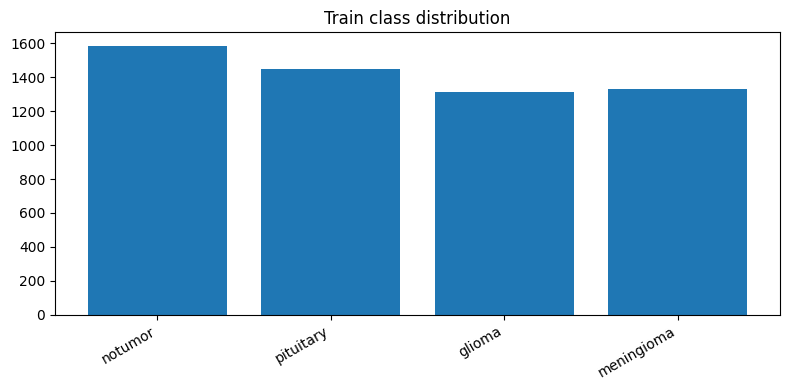

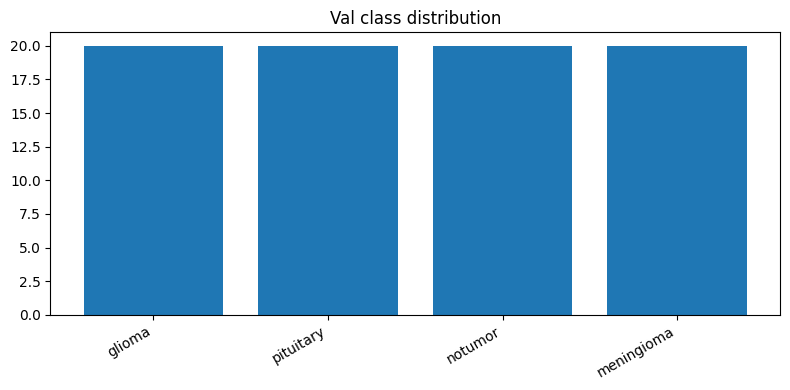

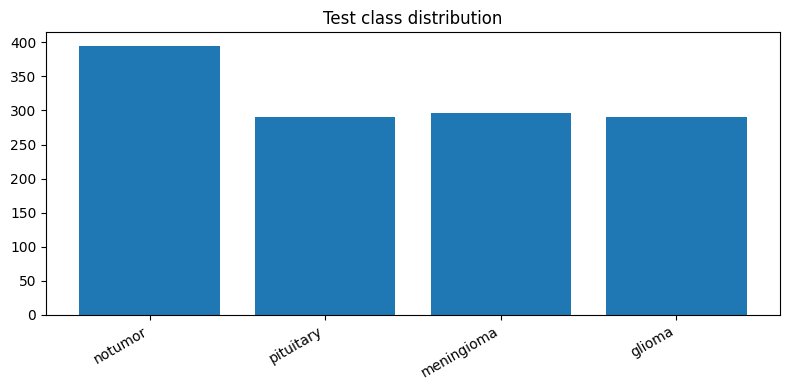

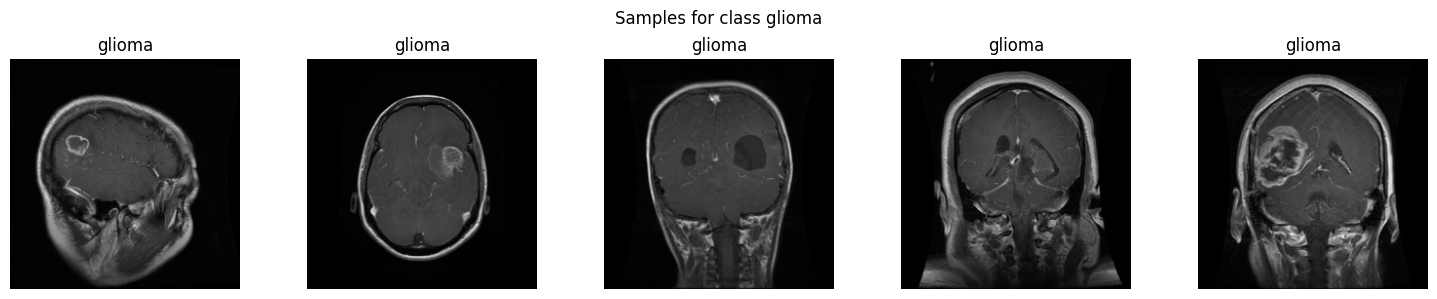

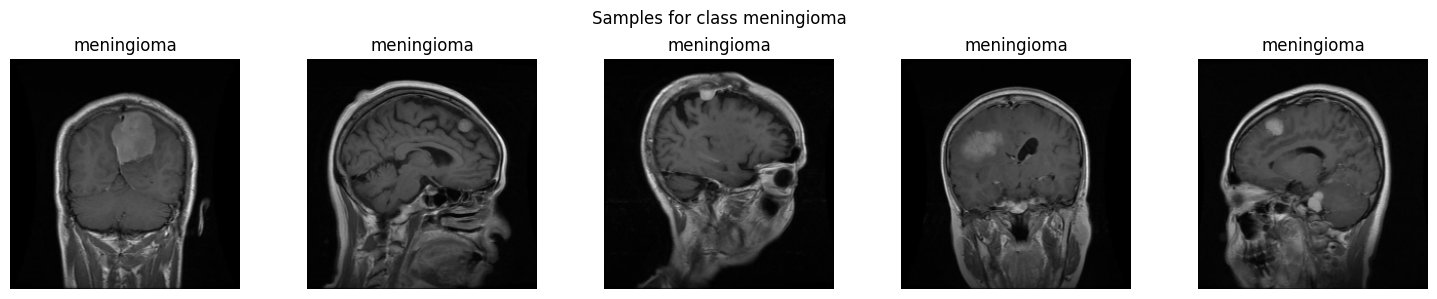

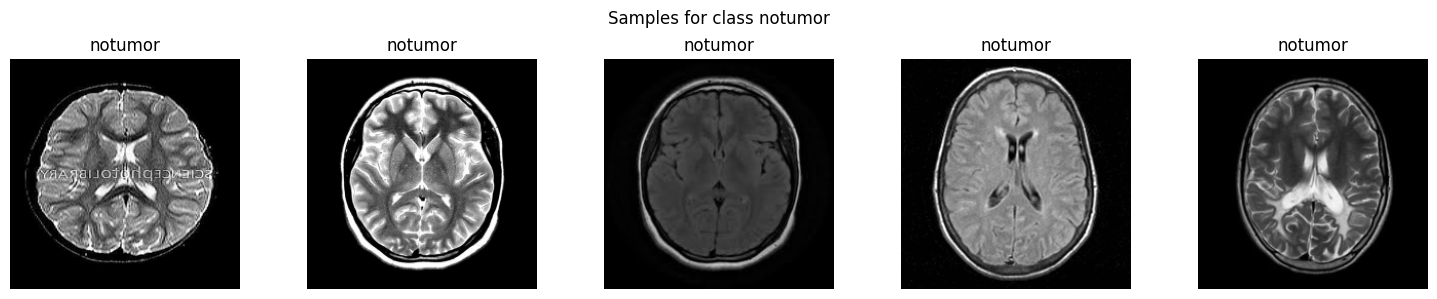

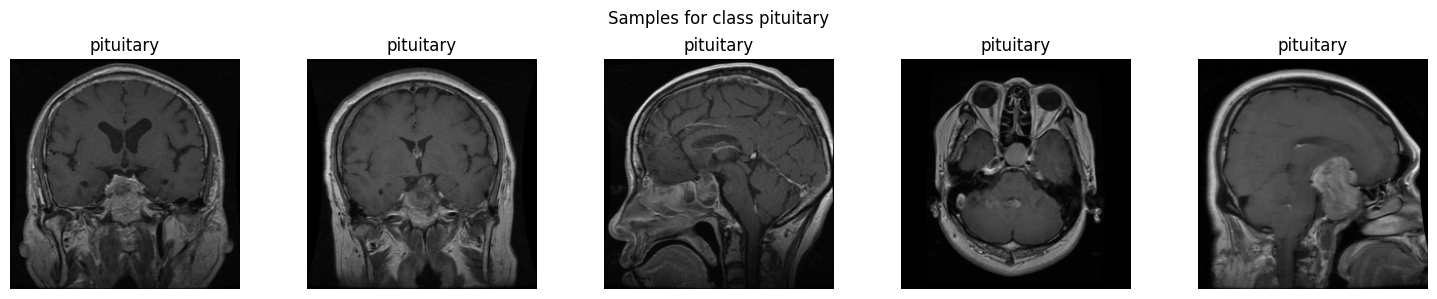

Train batches: 178, Val batches: 3, Test batches: 40
Data ready for CNN training in batches.


In [ ]:
# prepare_data.py
import cv2
import numpy as np
import random
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import collections

# ====== CONFIG ======
DATA_SPLIT = Path("./Data_split")   
IMG_SIZE = (224, 224)               
ALLOWED_EXT = {".jpg", ".jpeg", ".png", ".bmp"}
BATCH_SIZE = 32
ONE_HOT = True
RANDOM_SEED = 42
SAMPLES_PER_CLASS_TO_SHOW = 5
APPLY_OVER_SAMPLING = False
OVER_SAMPLING_THRESHOLD = 1.2
COMBINE_TRAIN_AND_VAL = False       
# ====================

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

def load_images_from_folder(split_dir: Path):
    images = []
    labels = []
    errors = []
    if not split_dir.exists():
        print(f"Warning: {split_dir} does not exist. Returning empty lists.")
        return images, labels, errors

    class_dirs = sorted([d for d in split_dir.iterdir() if d.is_dir()])
    for class_dir in class_dirs:
        class_name = class_dir.name
        for p in sorted(class_dir.iterdir()):
            if not p.is_file() or p.suffix.lower() not in ALLOWED_EXT:
                errors.append((str(p), "bad-extension"))
                continue
            try:
                img_bgr = cv2.imread(str(p))
                if img_bgr is None:
                    raise ValueError("cv2.imread returned None")
                img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
                img_resized = cv2.resize(img_rgb, IMG_SIZE, interpolation=cv2.INTER_AREA)
                images.append(img_resized)
                labels.append(class_name)
            except Exception as e:
                errors.append((str(p), repr(e)))
                continue
    return images, labels, errors

def shuffle_lists(images, labels):
    combined = list(zip(images, labels))
    random.shuffle(combined)
    if combined:
        images, labels = zip(*combined)
        return list(images), list(labels)
    return [], []

def plot_class_counts(labels, title="Class distribution"):
    counts = collections.Counter(labels)
    classes = list(counts.keys())
    values = [counts[c] for c in classes]
    plt.figure(figsize=(8,4))
    plt.bar(range(len(classes)), values)
    plt.xticks(range(len(classes)), classes, rotation=30, ha="right")
    plt.title(title)
    plt.tight_layout()
    plt.show()
    return counts

def show_samples(images, labels, n=SAMPLES_PER_CLASS_TO_SHOW):
    classes = sorted(set(labels))
    for cls in classes:
        idxs = [i for i,l in enumerate(labels) if l==cls]
        n_show = min(len(idxs), n)
        if n_show == 0:
            continue
        chosen = np.random.choice(idxs, n_show, replace=False)
        fig, axes = plt.subplots(1, n_show, figsize=(3*n_show,3))
        if n_show == 1:
            axes = [axes]
        for ax, idx in zip(axes, chosen):
            ax.imshow(images[idx].astype(np.uint8))
            ax.set_title(cls)
            ax.axis("off")
        plt.suptitle(f"Samples for class {cls}")
        plt.tight_layout()
        plt.show()

def oversample(X, y):
    unique, counts = np.unique(y, return_counts=True)
    max_count = counts.max()
    Xs, ys = [], []
    for cls, cnt in zip(unique, counts):
        idxs = np.where(y == cls)[0]
        X_cls = X[idxs]
        y_cls = y[idxs]
        reps = max_count // cnt
        rem = max_count % cnt
        X_dup = np.concatenate([X_cls]*reps + ([X_cls[np.random.choice(len(X_cls), rem)]],) if rem>0 else [])
        y_dup = np.concatenate([y_cls]*reps + ([y_cls[np.random.choice(len(y_cls), rem)]],) if rem>0 else [])
        Xs.append(X_dup)
        ys.append(y_dup)
    X_res = np.concatenate(Xs, axis=0)
    y_res = np.concatenate(ys, axis=0)
    perm = np.random.permutation(len(y_res))
    return X_res[perm], y_res[perm]

# ------------------------------
# LOAD DATA
# ------------------------------
TRAIN_DIR = DATA_SPLIT / "train"
VAL_DIR = DATA_SPLIT / "val"
TEST_DIR = DATA_SPLIT / "test"

X_train_list, y_train_list, errors_train = load_images_from_folder(TRAIN_DIR)
X_val_list, y_val_list, errors_val = load_images_from_folder(VAL_DIR)
X_test_list, y_test_list, errors_test = load_images_from_folder(TEST_DIR)

if COMBINE_TRAIN_AND_VAL:
    X_train_list += X_val_list
    y_train_list += y_val_list
    X_val_list, y_val_list = [], []

X_train_list, y_train_list = shuffle_lists(X_train_list, y_train_list)
X_val_list, y_val_list = shuffle_lists(X_val_list, y_val_list)
X_test_list, y_test_list = shuffle_lists(X_test_list, y_test_list)

X_train = np.array(X_train_list, dtype=np.float32) / 255.0
X_val = np.array(X_val_list, dtype=np.float32) / 255.0
X_test = np.array(X_test_list, dtype=np.float32) / 255.0

y_train = np.array(y_train_list)
y_val = np.array(y_val_list)
y_test = np.array(y_test_list)

le = LabelEncoder()
y_train_int = le.fit_transform(y_train)
y_val_int = le.transform(y_val) if len(y_val)>0 else np.array([], dtype=int)
y_test_int = le.transform(y_test) if len(y_test)>0 else np.array([], dtype=int)

if ONE_HOT:
    num_classes = len(le.classes_)
    y_train_final = to_categorical(y_train_int, num_classes)
    y_val_final = to_categorical(y_val_int, num_classes)
    y_test_final = to_categorical(y_test_int, num_classes)
else:
    y_train_final, y_val_final, y_test_final = y_train_int, y_val_int, y_test_int

# Check class balance and oversample if necessary
counts = collections.Counter(y_train)
ratio = max(counts.values()) / min(counts.values())
print("Train class counts:", counts, "max/min ratio:", ratio)
if ratio > OVER_SAMPLING_THRESHOLD and APPLY_OVER_SAMPLING:
    X_train, y_train_int = oversample(X_train, y_train_int)
    if ONE_HOT:
        y_train_final = to_categorical(y_train_int, num_classes)

# Visualize
plot_class_counts(y_train_list, "Train class distribution")
plot_class_counts(y_val_list, "Val class distribution")
plot_class_counts(y_test_list, "Test class distribution")
show_samples(X_train*255, le.inverse_transform(y_train_int))

# ------------------------------
# CREATE BATCHES USING tf.data
# ------------------------------
def create_dataset(X, y, batch_size=BATCH_SIZE, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(y), seed=RANDOM_SEED)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

train_ds = create_dataset(X_train, y_train_final)
val_ds = create_dataset(X_val, y_val_final)
test_ds = create_dataset(X_test, y_test_final)

print(f"Train batches: {len(list(train_ds))}, Val batches: {len(list(val_ds))}, Test batches: {len(list(test_ds))}")
print("Data ready for CNN training in batches.")


Detected num_classes = 4

=== MODEL SUMMARY ===


Model: "BrainTumor_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_25 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_26 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_27 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,010,788 (99.22 MB)

 Trainable params: 26,010,788 (99.22 MB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.
plot_model() failed — make sure pydot and graphviz are installed. Error: [Errno 2] No such file or directory: './models\\model_architecture.png'
Train steps (batches): 178
Val steps (batches): 3
Epoch 1/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 941ms/step - accuracy: 0.4291 - auc: 0.7363 - loss: 1.2161
Epoch 1: val_loss improved from None to 1.18016, saving model to ./models\best_cnn.h5


178/178 ━━━━━━━━━━━━━━━━━━━━ 171s 950ms/step - accuracy: 0.5508 - auc: 0.8315 - loss: 1.0401 - val_accuracy: 0.5500 - val_auc: 0.7726 - val_loss: 1.1802 - learning_rate: 1.0000e-04
Epoch 2/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 995ms/step - accuracy: 0.7358 - auc: 0.9236 - loss: 0.7288
Epoch 2: val_loss improved from 1.18016 to 0.85198, saving model to ./models\best_cnn.h5


178/178 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.7484 - auc: 0.9294 - loss: 0.6924 - val_accuracy: 0.6750 - val_auc: 0.8867 - val_loss: 0.8520 - learning_rate: 1.0000e-04
Epoch 3/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8124 - auc: 0.9568 - loss: 0.5431
Epoch 3: val_loss improved from 0.85198 to 0.64274, saving model to ./models\best_cnn.h5


178/178 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.8145 - auc: 0.9574 - loss: 0.5395 - val_accuracy: 0.7375 - val_auc: 0.9339 - val_loss: 0.6427 - learning_rate: 1.0000e-04
Epoch 4/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8425 - auc: 0.9672 - loss: 0.4710
Epoch 4: val_loss improved from 0.64274 to 0.61645, saving model to ./models\best_cnn.h5


178/178 ━━━━━━━━━━━━━━━━━━━━ 189s 1s/step - accuracy: 0.8445 - auc: 0.9676 - loss: 0.4675 - val_accuracy: 0.7500 - val_auc: 0.9397 - val_loss: 0.6165 - learning_rate: 1.0000e-04
Epoch 5/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8569 - auc: 0.9740 - loss: 0.4204
Epoch 5: val_loss did not improve from 0.61645
178/178 ━━━━━━━━━━━━━━━━━━━━ 187s 1s/step - accuracy: 0.8616 - auc: 0.9749 - loss: 0.4134 - val_accuracy: 0.7000 - val_auc: 0.9296 - val_loss: 0.6745 - learning_rate: 1.0000e-04
Epoch 6/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 950ms/step - accuracy: 0.8761 - auc: 0.9815 - loss: 0.3531
Epoch 6: val_loss improved from 0.61645 to 0.46246, saving model to ./models\best_cnn.h5


178/178 ━━━━━━━━━━━━━━━━━━━━ 170s 957ms/step - accuracy: 0.8850 - auc: 0.9827 - loss: 0.3409 - val_accuracy: 0.8125 - val_auc: 0.9666 - val_loss: 0.4625 - learning_rate: 1.0000e-04
Epoch 7/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 964ms/step - accuracy: 0.8954 - auc: 0.9863 - loss: 0.3069
Epoch 7: val_loss improved from 0.46246 to 0.42303, saving model to ./models\best_cnn.h5


178/178 ━━━━━━━━━━━━━━━━━━━━ 173s 971ms/step - accuracy: 0.8970 - auc: 0.9860 - loss: 0.3099 - val_accuracy: 0.8500 - val_auc: 0.9711 - val_loss: 0.4230 - learning_rate: 1.0000e-04
Epoch 8/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 956ms/step - accuracy: 0.9237 - auc: 0.9901 - loss: 0.2621
Epoch 8: val_loss improved from 0.42303 to 0.35985, saving model to ./models\best_cnn.h5


178/178 ━━━━━━━━━━━━━━━━━━━━ 172s 963ms/step - accuracy: 0.9251 - auc: 0.9904 - loss: 0.2585 - val_accuracy: 0.8625 - val_auc: 0.9816 - val_loss: 0.3599 - learning_rate: 1.0000e-04
Epoch 9/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 978ms/step - accuracy: 0.9236 - auc: 0.9912 - loss: 0.2453
Epoch 9: val_loss did not improve from 0.35985
178/178 ━━━━━━━━━━━━━━━━━━━━ 175s 982ms/step - accuracy: 0.9289 - auc: 0.9919 - loss: 0.2352 - val_accuracy: 0.8250 - val_auc: 0.9761 - val_loss: 0.3946 - learning_rate: 1.0000e-04
Epoch 10/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9422 - auc: 0.9943 - loss: 0.2074
Epoch 10: val_loss did not improve from 0.35985
178/178 ━━━━━━━━━━━━━━━━━━━━ 193s 1s/step - accuracy: 0.9401 - auc: 0.9944 - loss: 0.2044 - val_accuracy: 0.8500 - val_auc: 0.9774 - val_loss: 0.4083 - learning_rate: 1.0000e-04
Epoch 11/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9410 - auc: 0.9952 - loss: 0.1907
Epoch 11: val_loss improved from 0.35985 to 0.30921, saving mod

178/178 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.9452 - auc: 0.9953 - loss: 0.1886 - val_accuracy: 0.9250 - val_auc: 0.9859 - val_loss: 0.3092 - learning_rate: 1.0000e-04
Epoch 12/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9563 - auc: 0.9967 - loss: 0.1625
Epoch 12: val_loss did not improve from 0.30921
178/178 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.9536 - auc: 0.9965 - loss: 0.1659 - val_accuracy: 0.8625 - val_auc: 0.9822 - val_loss: 0.3836 - learning_rate: 1.0000e-04
Epoch 13/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9584 - auc: 0.9968 - loss: 0.1517
Epoch 13: val_loss did not improve from 0.30921
178/178 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.9607 - auc: 0.9970 - loss: 0.1483 - val_accuracy: 0.8625 - val_auc: 0.9865 - val_loss: 0.3804 - learning_rate: 1.0000e-04
Epoch 14/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9566 - auc: 0.9973 - loss: 0.1514
Epoch 14: ReduceLROnPlateau reducing learning rate to 4.99999987368937

178/178 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.9795 - auc: 0.9991 - loss: 0.1034 - val_accuracy: 0.9125 - val_auc: 0.9936 - val_loss: 0.2463 - learning_rate: 5.0000e-05
Epoch 16/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9825 - auc: 0.9989 - loss: 0.0992
Epoch 16: val_loss improved from 0.24633 to 0.24631, saving model to ./models\best_cnn.h5


178/178 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.9806 - auc: 0.9990 - loss: 0.1032 - val_accuracy: 0.9000 - val_auc: 0.9934 - val_loss: 0.2463 - learning_rate: 5.0000e-05
Epoch 17/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9856 - auc: 0.9993 - loss: 0.0881
Epoch 17: val_loss did not improve from 0.24631
178/178 ━━━━━━━━━━━━━━━━━━━━ 210s 1s/step - accuracy: 0.9847 - auc: 0.9994 - loss: 0.0888 - val_accuracy: 0.8875 - val_auc: 0.9817 - val_loss: 0.3525 - learning_rate: 5.0000e-05
Epoch 18/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9881 - auc: 0.9995 - loss: 0.0810
Epoch 18: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 18: val_loss did not improve from 0.24631
178/178 ━━━━━━━━━━━━━━━━━━━━ 212s 1s/step - accuracy: 0.9866 - auc: 0.9996 - loss: 0.0820 - val_accuracy: 0.8875 - val_auc: 0.9772 - val_loss: 0.3845 - learning_rate: 5.0000e-05
Epoch 19/30
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9868 - auc: 0.9995 - loss:

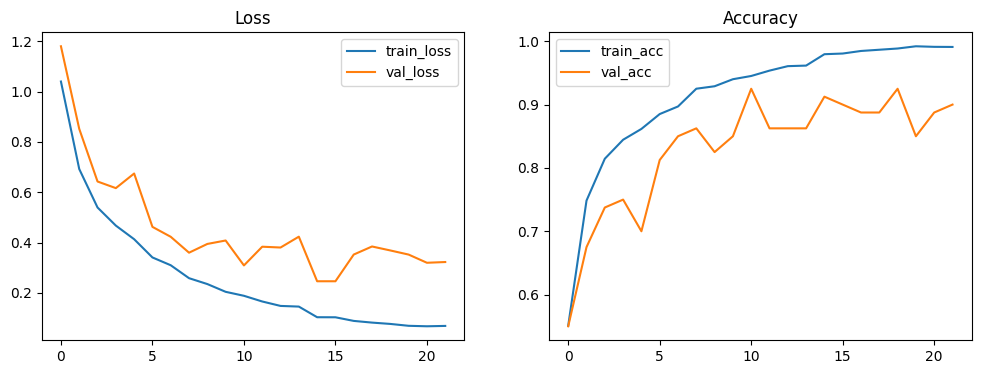

Saved final model to ./models\final_model.h5


In [19]:
# train_cnn.py
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.utils import plot_model
import time
import matplotlib.pyplot as plt
import os

# -------------------- CONFIG / HYPERPARAMS --------------------
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3

LEARNING_RATE = 1e-4
BATCH_SIZE = 32            
EPOCHS = 30
PATIENCE_ES = 6           
PATIENCE_RLR = 3           
MODEL_DIR = "./models"
MODEL_FILENAME = "best_cnn.h5"
WEIGHT_DECAY = 1e-4        
DROPOUT_RATE = 0.4

os.makedirs(MODEL_DIR, exist_ok=True)


def build_cnn(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), num_classes=4):

    inputs = layers.Input(shape=input_shape)

    # Block 1
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(inputs)
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.15)(x)

    # Block 2
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.2)(x)

    # Block 3
    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Dropout(0.25)(x)

    # Classification head
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation="relu", kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    x = layers.Dropout(DROPOUT_RATE)(x)
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(WEIGHT_DECAY))(x)
    x = layers.Dropout(DROPOUT_RATE)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs=inputs, outputs=outputs, name="BrainTumor_CNN")
    return model

try:
    sample_batch = next(iter(train_ds))
    y_sample = sample_batch[1]
    if len(y_sample.shape) == 2:    # one-hot
        num_classes = y_sample.shape[1]
    elif len(y_sample.shape) == 1:  # integer labels
        num_classes = int(tf.reduce_max(y_sample).numpy()) + 1
    else:
        num_classes = 4
except Exception:
    num_classes = 4

print("Detected num_classes =", num_classes)

model = build_cnn(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), num_classes=num_classes)

optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = "categorical_crossentropy"  #  categorical_crossentropy for one-hot labels
metrics = ["accuracy", tf.keras.metrics.AUC(name="auc")]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

print("\n=== MODEL SUMMARY ===")
model.summary()

# Save architecture plot (requires pydot + graphviz)
plot_path = os.path.join(MODEL_DIR, "model_architecture.png")
try:
    plot_model(model, to_file=plot_path, show_shapes=True, show_layer_names=True)
    from PIL import Image
    img = Image.open(plot_path)
    display(img)   # Jupyter: shows image inline; in script this may not show
    print(f"Saved architecture plot to {plot_path}")
except Exception as e:
    print("plot_model() failed — make sure pydot and graphviz are installed. Error:", e)

callbacks = [
    EarlyStopping(monitor="val_loss", patience=PATIENCE_ES, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=PATIENCE_RLR, verbose=1, min_lr=1e-7),
    ModelCheckpoint(os.path.join(MODEL_DIR, MODEL_FILENAME), monitor="val_loss", save_best_only=True, verbose=1)
]

def get_steps(ds):
    try:
        return tf.data.experimental.cardinality(ds).numpy()
    except Exception:
        return None

train_steps = get_steps(train_ds)
val_steps = get_steps(val_ds)

print("Train steps (batches):", train_steps)
print("Val steps (batches):", val_steps)

start_time = time.time()
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks,
    verbose=1
)
elapsed = time.time() - start_time
print(f"Training finished in {elapsed/60:.2f} minutes ({elapsed:.1f} seconds).")

print("\n=== Evaluate on test set ===")
test_results = model.evaluate(test_ds, verbose=1)
print("Test results:", dict(zip(model.metrics_names, test_results)))

def plot_history(hist):
    plt.figure(figsize=(12,4))
    # loss
    plt.subplot(1,2,1)
    plt.plot(hist.history['loss'], label='train_loss')
    plt.plot(hist.history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.legend()
    # accuracy
    plt.subplot(1,2,2)
    plt.plot(hist.history['accuracy'], label='train_acc')
    plt.plot(hist.history['val_accuracy'], label='val_acc')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

plot_history(history)

# Save final model (if not already saved by ModelCheckpoint)
final_path = os.path.join(MODEL_DIR, "final_model.h5")
model.save(final_path)
print("Saved final model to", final_path)


Loading best model weights from ./models\best_cnn.h5
Best model (checkpoint) saved to: ./models\best_cnn.h5

Evaluating on test set:
40/40 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - accuracy: 0.9685 - auc: 0.9961 - loss: 0.1514
Test results: {'loss': 0.15135875344276428, 'compile_metrics': 0.968528687953949}


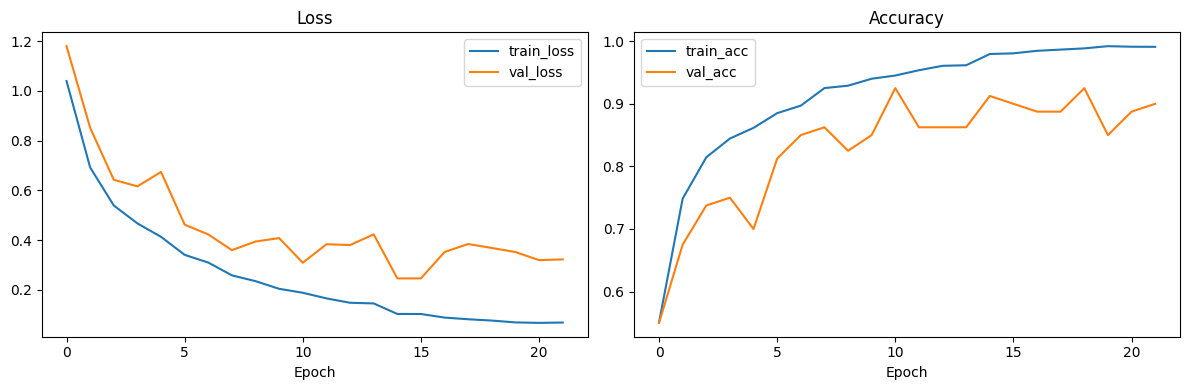

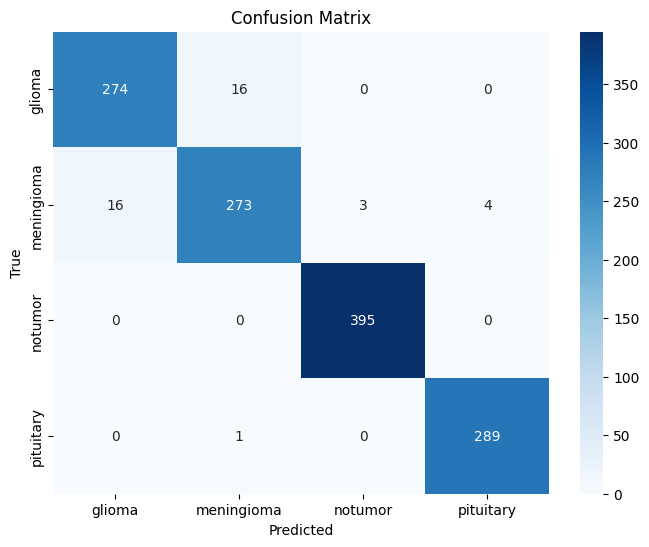

Classification report:

              precision    recall  f1-score   support

      glioma     0.9448    0.9448    0.9448       290
  meningioma     0.9414    0.9223    0.9317       296
     notumor     0.9925    1.0000    0.9962       395
   pituitary     0.9863    0.9966    0.9914       290

    accuracy                         0.9685      1271
   macro avg     0.9663    0.9659    0.9661      1271
weighted avg     0.9683    0.9685    0.9684      1271

Showing 6 correct predictions:


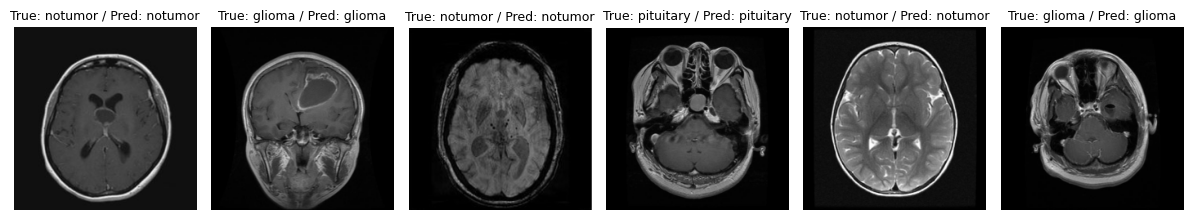

Showing 6 incorrect predictions:


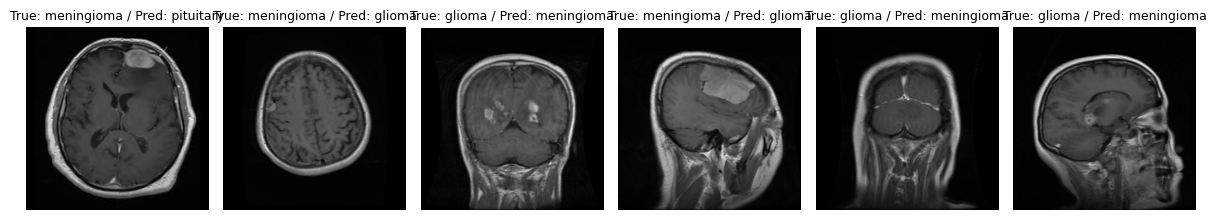

Done: training/evaluation/visualization complete.


In [20]:
# train_and_evaluate_cell.py
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# ---------- CONFIG ----------
# If model is already trained and you only want evaluation, set already_trained=True.
already_trained = True

MODEL_DIR = "./models"
MODEL_FILENAME = "best_cnn.h5"
MODEL_PATH = os.path.join(MODEL_DIR, MODEL_FILENAME)
os.makedirs(MODEL_DIR, exist_ok=True)

# Training hyperparams (only used if we call model.fit here)
EPOCHS = 30
PATIENCE_ES = 6
PATIENCE_RLR = 3

# How many example images to show for correct/incorrect
N_CORRECT = 6
N_INCORRECT = 6

# ---------- CALLBACKS ----------
checkpoint_cb = ModelCheckpoint(MODEL_PATH, monitor="val_loss", save_best_only=True, verbose=1)
early_cb = EarlyStopping(monitor="val_loss", patience=PATIENCE_ES, restore_best_weights=True, verbose=1)
rlr_cb = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=PATIENCE_RLR, min_lr=1e-7, verbose=1)
cbs = [checkpoint_cb, early_cb, rlr_cb]

# ---------- TRAIN ----------
if not already_trained:
    print("Starting training with model.fit() ...")
    t0 = time.time()
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=cbs,
        verbose=1
    )
    elapsed = time.time() - t0
    print(f"Training finished in {elapsed/60:.2f} minutes ({elapsed:.1f} seconds).")
else:
    # if already trained, try to load history from variable `history` if available
    try:
        history  # noqa
    except NameError:
        history = None
    if os.path.exists(MODEL_PATH):
        print(f"Loading best model weights from {MODEL_PATH}")
        model.load_weights(MODEL_PATH)
    else:
        print("No saved model found at", MODEL_PATH)

# ---------- SAVE (ModelCheckpoint already saved best model) ----------
print("Best model (checkpoint) saved to:", MODEL_PATH)

# ---------- EVALUATE ON TEST SET ----------
print("\nEvaluating on test set:")
eval_res = model.evaluate(test_ds, verbose=1)
print("Test results:", dict(zip(model.metrics_names, eval_res)))

# ---------- PLOT TRAINING CURVES ----------
def plot_history(history_obj):
    if history_obj is None:
        print("No history object to plot (model was not trained in this session).")
        return
    hist = history_obj.history
    plt.figure(figsize=(12,4))
    # loss
    plt.subplot(1,2,1)
    plt.plot(hist.get('loss', []), label='train_loss')
    plt.plot(hist.get('val_loss', []), label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    # accuracy
    plt.subplot(1,2,2)
    # try multiple possible accuracy keys
    acc_key = 'accuracy' if 'accuracy' in hist else ('acc' if 'acc' in hist else None)
    val_acc_key = 'val_' + acc_key if acc_key else None
    if acc_key and val_acc_key:
        plt.plot(hist.get(acc_key, []), label='train_acc')
        plt.plot(hist.get(val_acc_key, []), label='val_acc')
        plt.title('Accuracy')
        plt.xlabel('Epoch')
        plt.legend()
    else:
        print("No accuracy keys found in history to plot.")
    plt.tight_layout()
    plt.show()

plot_history(history if 'history' in globals() else None)

# ---------- PREDICTIONS FOR CONFUSION MATRIX & REPORT ----------
# Collect ground-truth labels and predictions over the entire test set
y_true_list = []
y_pred_list = []
probs_list = []

for batch in test_ds:
    X_batch, y_batch = batch
    # handle one-hot or integer labels
    if len(y_batch.shape) == 2:  # one-hot
        y_true_batch = np.argmax(y_batch.numpy(), axis=1)
    else:
        y_true_batch = y_batch.numpy().astype(int)
    probs = model.predict(X_batch, verbose=0)
    if probs.ndim == 1:
        # binary probs? turn into two-class format
        probs = np.vstack([1-probs, probs]).T
    y_pred_batch = np.argmax(probs, axis=1)
    y_true_list.append(y_true_batch)
    y_pred_list.append(y_pred_batch)
    probs_list.append(probs)

if len(y_true_list) == 0:
    raise RuntimeError("test_ds yielded no data — check test dataset pipeline.")

y_true = np.concatenate(y_true_list, axis=0)
y_pred = np.concatenate(y_pred_list, axis=0)
probs_all = np.concatenate(probs_list, axis=0)

# If you have a LabelEncoder `le`, obtain class names, else use integer labels
try:
    class_names = list(le.classes_)
except Exception:
    # fallback to integer labels
    ncls = probs_all.shape[1]
    class_names = [str(i) for i in range(ncls)]

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.ylabel('True')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification report
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print("Classification report:\n")
print(report)

# ---------- SHOW EXAMPLES OF CORRECT & INCORRECT PREDICTIONS ----------
# We'll collect a few examples by iterating again over test_ds (images in original [0..1] floats)
correct_imgs = []
correct_titles = []
incorrect_imgs = []
incorrect_titles = []

# function to convert one-hot label to int if necessary
def label_to_int(y):
    if len(y.shape) == 0:
        return int(y)
    if len(y.shape) == 1:
        return int(y)
    if len(y.shape) == 2:
        return int(np.argmax(y))
    return int(y)

# iterate until we collect enough examples or exhaust dataset
for batch in test_ds:
    X_batch, y_batch = batch
    probs = model.predict(X_batch, verbose=0)
    y_batch_int = np.argmax(y_batch.numpy(), axis=1) if len(y_batch.shape)==2 else y_batch.numpy().astype(int)
    y_pred_batch = np.argmax(probs, axis=1)
    for i in range(X_batch.shape[0]):
        img = X_batch[i].numpy()
        true_lbl = y_batch_int[i]
        pred_lbl = int(y_pred_batch[i])
        title = f"True: {class_names[true_lbl]} / Pred: {class_names[pred_lbl]}"
        if true_lbl == pred_lbl and len(correct_imgs) < N_CORRECT:
            correct_imgs.append(img)
            correct_titles.append(title)
        elif true_lbl != pred_lbl and len(incorrect_imgs) < N_INCORRECT:
            incorrect_imgs.append(img)
            incorrect_titles.append(title)
    if len(correct_imgs) >= N_CORRECT and len(incorrect_imgs) >= N_INCORRECT:
        break

def show_image_grid(imgs, titles, rows=1, cols=6, cmap=None):
    plt.figure(figsize=(cols*2, rows*2.2))
    for i, (img, t) in enumerate(zip(imgs, titles)):
        ax = plt.subplot(rows, cols, i+1)
        # images are normalized [0,1] so scale to 0-1 for imshow
        if img.max() <= 1.0:
            ax.imshow(np.clip(img,0,1))
        else:
            ax.imshow(np.clip(img,0,255).astype(np.uint8))
        ax.set_title(t, fontsize=9)
        ax.axis("off")
    plt.tight_layout()
    plt.show()

if correct_imgs:
    print(f"Showing {len(correct_imgs)} correct predictions:")
    show_image_grid(correct_imgs, correct_titles, rows=1, cols=len(correct_imgs))
else:
    print("No correct predictions collected to display.")

if incorrect_imgs:
    print(f"Showing {len(incorrect_imgs)} incorrect predictions:")
    show_image_grid(incorrect_imgs, incorrect_titles, rows=1, cols=len(incorrect_imgs))
else:
    print("No incorrect predictions collected to display.")

# ---------- Done ----------
print("Done: training/evaluation/visualization complete.")


In [30]:
# save_and_predict_fixed.py
import numpy as np
import cv2
from pathlib import Path
import os
import tensorflow as tf

# CONFIG (change if needed)
DEFAULT_MODEL_PATH = "models/best_cnn.h5"            # your existing model file
DEFAULT_LABELS_PATH = "models/label_classes.npy"
DATA_SPLIT_TRAIN = Path("./Data_split/train")       # used to infer labels if missing
IMG_SIZE_DEFAULT = (224, 224)

# --- helper: create label_classes.npy from train folder ---
def create_label_file_from_train(train_root: Path = DATA_SPLIT_TRAIN, label_path: str = DEFAULT_LABELS_PATH):
    """
    Creates label_classes.npy by listing subfolders of train_root (sorted).
    Returns the list of classes saved.
    """
    train_root = Path(train_root)
    if not train_root.exists():
        raise FileNotFoundError(f"Train root not found at {train_root}. Cannot infer classes.")
    class_dirs = sorted([d.name for d in train_root.iterdir() if d.is_dir()])
    if len(class_dirs) == 0:
        raise RuntimeError(f"No class subfolders found inside {train_root}.")
    os.makedirs(Path(label_path).parent, exist_ok=True)
    np.save(label_path, np.array(class_dirs, dtype=object))
    print(f"Saved {len(class_dirs)} class names to {label_path}: {class_dirs}")
    return class_dirs

# --- preprocessing (same as before) ---
def preprocess_image_for_model(path, img_size=IMG_SIZE_DEFAULT):
    p = Path(path)
    if not p.exists():
        raise FileNotFoundError(f"File not found: {p}")
    img_bgr = cv2.imread(str(p))
    if img_bgr is None:
        raise ValueError(f"cv2.imread failed to read {path} (corrupted or not an image).")
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img_rgb, img_size, interpolation=cv2.INTER_AREA)
    arr = img_resized.astype("float32") / 255.0
    arr = np.expand_dims(arr, axis=0)
    return arr

# --- improved predict_image: falls back to creating labels file if missing ---
def predict_image(path,
                  model_path=DEFAULT_MODEL_PATH,
                  label_path=DEFAULT_LABELS_PATH,
                  img_size=IMG_SIZE_DEFAULT,
                  save_label_if_inferred=True):
    """
    Predict a single image. If label_path missing, attempt to infer classes from DATA_SPLIT_TRAIN and save them.
    Returns dict with 'pred_class','pred_index','probs','class_names','probs_sorted'.
    """
    # load model
    if not Path(model_path).exists():
        raise FileNotFoundError(f"Model file not found at {model_path}")
    model = tf.keras.models.load_model(model_path)

    # ensure class mapping exists (try load; if missing, infer from train dir)
    if not Path(label_path).exists():
        print(f"Label file {label_path} not found — attempting to infer from {DATA_SPLIT_TRAIN} ...")
        classes = create_label_file_from_train(train_root=DATA_SPLIT_TRAIN, label_path=label_path)
        if not classes:
            raise RuntimeError("Failed to infer classes from train folder.")
    else:
        classes = list(np.load(label_path, allow_pickle=True))

    # preprocess and predict
    X = preprocess_image_for_model(path, img_size=img_size)
    probs = model.predict(X, verbose=0)
    probs1 = probs[0] if probs.ndim==2 and probs.shape[0]==1 else probs.flatten()
    pred_idx = int(np.argmax(probs1))
    pred_label = classes[pred_idx] if pred_idx < len(classes) else str(pred_idx)

    prob_pairs_sorted = sorted(list(zip(classes, probs1.tolist())), key=lambda x: x[1], reverse=True)
    return {
        "pred_class": pred_label,
        "pred_index": pred_idx,
        "probs": probs1,
        "class_names": classes,
        "probs_sorted": prob_pairs_sorted
    }

# --- convenience CLI usage ---
if __name__ == "__main__":
    # if you don't have label file, create it once:
    if not Path(DEFAULT_LABELS_PATH).exists():
        print("Creating label file from training folders...")
        create_label_file_from_train()

    # example test
    test_image = "./Data_split/test/glioma/Te-gl_0130.jpg"
    res = predict_image(test_image, model_path=DEFAULT_MODEL_PATH, label_path=DEFAULT_LABELS_PATH)
    print("Predicted:", res["pred_class"])
    print("Top probabilities:")
    for cls, p in res["probs_sorted"][:5]:
        print(f"  {cls}: {p:.4f}")


Predicted: glioma
Top probabilities:
  glioma: 0.9999
  meningioma: 0.0001
  notumor: 0.0000
  pituitary: 0.0000
